<a href="https://colab.research.google.com/github/geoaigroup/models-deployment/blob/main/scripts/process_large_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the required packages

import torch
import argparse
import os
import cv2

from segmentation_models_pytorch import Unet

from skimage.io import imread,imsave
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio

from utils import *
from color_map import cm_data
from rasterio.features import shapes
from tqdm.notebook import tqdm

/home/jamada/.venv/eo-xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load your model with pre-trained model weights

MODEL_PATH = './pretrained_model'
THRESH = 0.5
ALPHA = 0.85
SCALE = None


model = Unet(
        encoder_name = "tu-tf_efficientnet_b0",
        encoder_depth= 5,
        encoder_weights = None,
        decoder_use_batchnorm = True,
        decoder_channels = (256, 128, 64, 32, 16),
        decoder_attention_type = None,
        in_channels= 3,
        classes = 3,
        activation = 'sigmoid',
        aux_params = None,
    )

model = load_model(model,MODEL_PATH)
model.cuda()

Unet(
  (encoder): TimmUniversalEncoder(
    (model): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid(

In [3]:
# Define the CAM-based Extensions classes 
from PIL import Image
import numpy as np
import ttach as tta
import sys
import torch
import warnings
from skimage.io import imread
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
import argparse
import os
from typing import Callable, List
import cv2
import tqdm
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from skimage.segmentation import watershed
from skimage.measure import label
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.find_layers import replace_layer_recursive

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Grad-Cam Classes
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients
            # self.gradients = [torch.mul(t, -1) for t in self.gradients]

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()




class AblationLayer(torch.nn.Module):
    def __init__(self):
        super(AblationLayer, self).__init__()

    def objectiveness_mask_from_svd(self, activations, threshold=0.01):
        """ Experimental method to get a binary mask to compare if the activation is worth ablating.
            The idea is to apply the EigenCAM method by doing PCA on the activations.
            Then we create a binary mask by comparing to a low threshold.
            Areas that are masked out, are probably not interesting anyway.
        """

        projection = get_2d_projection(activations[None, :])[0, :]
        projection = np.abs(projection)
        projection = projection - projection.min()
        projection = projection / projection.max()
        projection = projection > threshold
        return projection

    def activations_to_be_ablated(
            self,
            activations,
            ratio_channels_to_ablate=1.0):
        """ Experimental method to get a binary mask to compare if the activation is worth ablating.
            Create a binary CAM mask with objectiveness_mask_from_svd.
            Score each Activation channel, by seeing how much of its values are inside the mask.
            Then keep the top channels.

        """
        if ratio_channels_to_ablate == 1.0:
            self.indices = np.int32(range(activations.shape[0]))
            return self.indices

        projection = self.objectiveness_mask_from_svd(activations)

        scores = []
        for channel in activations:
            normalized = np.abs(channel)
            normalized = normalized - normalized.min()
            normalized = normalized / np.max(normalized)
            score = (projection * normalized).sum() / normalized.sum()
            scores.append(score)
        scores = np.float32(scores)

        indices = list(np.argsort(scores))
        high_score_indices = indices[::-
                                     1][: int(len(indices) *
                                              ratio_channels_to_ablate)]
        low_score_indices = indices[: int(
            len(indices) * ratio_channels_to_ablate)]
        self.indices = np.int32(high_score_indices + low_score_indices)
        return self.indices

    def set_next_batch(
            self,
            input_batch_index,
            activations,
            num_channels_to_ablate):
        """ This creates the next batch of activations from the layer.
            Just take corresponding batch member from activations, and repeat it num_channels_to_ablate times.
        """
        self.activations = activations[input_batch_index, :, :, :].clone(
        ).unsqueeze(0).repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x, test=None):
        output = self.activations
        for i in range(output.size(0)):
            # Commonly the minimum activation will be 0,
            # And then it makes sense to zero it out.
            # However depending on the architecture,
            # If the values can be negative, we use very negative values
            # to perform the ablation, deviating from the paper.
            if torch.min(output) == 0:
                output[i, self.indices[i], :] = 0
            else:
                ABLATION_VALUE = 1e7
                output[i, self.indices[i], :] = torch.min(
                    output) - ABLATION_VALUE

        return output




class GRADCAM_Extensions:
    def __init__(self, extension, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)
        self.extension = extension

    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = input_tensor.size(-1), input_tensor.size(-2)
        # print('Activations list size: ', len(activations_list))
        # print('Gradients list size: ', len(grads_list))
        # print('Target layer size: ', len(self.target_layers))

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            # print('\t\t\t-----------------------\n')
            # print('Target Layer ', i + 1, ': ', target_layer)
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]


            if  self.extension == "grad_cam":
                weights = np.mean(layer_grads, axis=(2, 3))
                weighs_up = weights[:, :, None, None] 
                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)

            elif self.extension == "hires_cam":
                elementwise_activations = layer_grads * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(elementwise_activations)
                else:
                    cam = elementwise_activations.sum(axis=1)

            elif self.extension == "ew_cam":
                elementwise_activations = np.maximum(layer_grads * layer_activations, 0)
                if eigen_smooth:
                    cam = get_2d_projection(elementwise_activations)
                else:
                    cam = elementwise_activations.sum(axis=1)
                    
            elif self.extension == "grad_cam_pp":
                grads_power_2 = layer_grads**2
                grads_power_3 = grads_power_2 * layer_grads
                # Equation 19 in https://arxiv.org/abs/1710.11063
                sum_activations = np.sum(layer_activations, axis=(2, 3))
                eps = 0.000001
                aij = grads_power_2 / (2 * grads_power_2 + sum_activations[:, :, None, None] * grads_power_3 + eps)
                # Now bring back the ReLU from eq.7 in the paper,
                # And zero out aijs where the activations are 0
                aij = np.where(layer_grads != 0, aij, 0)
                weights = np.maximum(layer_grads, 0) * aij
                weights = np.sum(weights, axis=(2, 3))
                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)

            

            elif self.extension == "x_grad_cam":
                sum_activations = np.sum(layer_activations, axis=(2, 3))
                eps = 1e-7
                weights = layer_grads * layer_activations / \
                (sum_activations[:, :, None, None] + eps)
                weights = weights.sum(axis=(2, 3))
                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)

            
            elif self.extension == "score_cam":
                with torch.no_grad():
                    upsample = torch.nn.UpsamplingBilinear2d(size=input_tensor.shape[-2:])
                    activation_tensor = torch.from_numpy(layer_activations)
                    if self.cuda:
                        activation_tensor = activation_tensor.cuda()
                    upsampled = upsample(activation_tensor)
                    maxs = upsampled.view(upsampled.size(0), upsampled.size(1), -1).max(dim=-1)[0]
                    mins = upsampled.view(upsampled.size(0), upsampled.size(1), -1).min(dim=-1)[0]
                    maxs, mins = maxs[:, :, None, None], mins[:, :, None, None]
                    upsampled = (upsampled - mins) / (maxs - mins)
    
                    input_tensors = input_tensor[:, None, :, :] * upsampled[:, :, None, :, :]
                    if hasattr(self, "batch_size"):
                        BATCH_SIZE = self.batch_size
                    else:
                        BATCH_SIZE = 8
                 
    
                    scores = []
                    for target, tensor in zip(targets, input_tensors):
                        for i in tqdm.tqdm(range(0, tensor.size(0), BATCH_SIZE)):
                            batch = tensor[i: i + BATCH_SIZE, :]
                            outputs = [target(o).cpu().item() for o in self.model(batch)]
                            scores.extend(outputs)
                    scores = torch.Tensor(scores)
                    scores = scores.view(layer_activations.shape[0], layer_activations.shape[1])
                    weights = torch.nn.Softmax(dim=-1)(scores).numpy()

                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)

            elif self.extension == "layer_cam":
                spatial_weighted_activations = np.maximum(layer_grads, 0) * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(spatial_weighted_activations)
                else:
                    cam = spatial_weighted_activations.sum(axis=1)


            elif self.extension == "eigen_cam":
                cam = get_2d_projection(layer_activations) 

            elif self.extension == "eigen_grad_cam":
                cam = get_2d_projection(layer_grads * layer_activations)
            
            else:
                print("Unkown Extension. Please use one of the following: grad_cam - hires_cam - ew_cam -  grad_cam_pp - x_grad_cam - score_cam - layer_cam - eigen_cam -  eigen_grad_cam")
                
                    

            cam = np.maximum(cam, 0)
            # print("Cam image  Max per layer size: ", cam.shape)
            scaled = scale_cam_image(cam, target_size)
            # print("Scaled Cam image per layer size: ", scaled.shape)
            cam_per_target_layer.append(scaled[:, None, :])

        # print("Cam image list size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        # print("Cam image list Concat size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # print("Cam image list (max) size: ", len(cam_per_target_layer))
        result = np.mean(cam_per_target_layer, axis=1) # old: mean 
        # print("+++ Averaged CAM list size: ", result.shape)

        
        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True




class GRADCAMEXTENDED_AblationCAM:
    def __init__(self, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = False,
                 uses_gradients: bool = True, 
                 ablation_layer: torch.nn.Module = AblationLayer(),
                 batch_size: int = 32,
                 ratio_channels_to_ablate: float = 1.0) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)
        self.batch_size = batch_size
        self.ablation_layer = ablation_layer
        self.ratio_channels_to_ablate = ratio_channels_to_ablate


    def save_activation(self, module, input, output) -> None:
        """ Helper function to save the raw activations from the target layer """
        self.activations = output

    def assemble_ablation_scores(self,
                                 new_scores: list,
                                 original_score: float,
                                 ablated_channels: np.ndarray,
                                 number_of_channels: int) -> np.ndarray:
        """ Take the value from the channels that were ablated,
            and just set the original score for the channels that were skipped """

        index = 0
        result = []
        sorted_indices = np.argsort(ablated_channels)
        ablated_channels = ablated_channels[sorted_indices]
        new_scores = np.float32(new_scores)[sorted_indices]

        for i in range(number_of_channels):
            if index < len(ablated_channels) and ablated_channels[index] == i:
                weight = new_scores[index]
                index = index + 1
            else:
                weight = original_score
            result.append(weight)

        return result


    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = input_tensor.size(-1), input_tensor.size(-2)
        # print('Activations list size: ', len(activations_list))
        # print('Gradients list size: ', len(grads_list))
        # print('Target layer size: ', len(self.target_layers))

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            # print('\t\t\t-----------------------\n')
            # print('Target Layer ', i + 1, ': ', target_layer)
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            
            # get weights
            # Do a forward pass, compute the target scores, and cache the
            # activations
            handle = target_layer.register_forward_hook(self.save_activation)
            with torch.no_grad():
                outputs = self.model(input_tensor)
                handle.remove()
                original_scores = np.float32(
                    [target(output).cpu().item() for target, output in zip(targets, outputs)])
    
            # Replace the layer with the ablation layer.
            # When we finish, we will replace it back, so the original model is
            # unchanged.
            ablation_layer = self.ablation_layer
            replace_layer_recursive(self.model, target_layer, ablation_layer)
            
            number_of_channels = layer_activations.shape[1]
            weights = []
            # This is a "gradient free" method, so we don't need gradients here.
            with torch.no_grad():
                # Loop over each of the batch images and ablate activations for it.
                for batch_index, (target, tensor) in enumerate(
                        zip(targets, input_tensor)):
                    new_scores = []
                    batch_tensor = tensor.repeat(self.batch_size, 1, 1, 1)
    
                    # Check which channels should be ablated. Normally this will be all channels,
                    # But we can also try to speed this up by using a low
                    # ratio_channels_to_ablate.
                    channels_to_ablate = ablation_layer.activations_to_be_ablated(
                        layer_activations[batch_index, :], self.ratio_channels_to_ablate)
                    number_channels_to_ablate = len(channels_to_ablate)
                    
                    for i in tqdm.tqdm(range(0, number_channels_to_ablate, self.batch_size)):
                        if i + self.batch_size > number_channels_to_ablate:
                            batch_tensor = batch_tensor[:(number_channels_to_ablate - i)]
    
                        # Change the state of the ablation layer so it ablates the next channels.
                        # TBD: Move this into the ablation layer forward pass.
                        ablation_layer.set_next_batch(input_batch_index=batch_index,activations=self.activations,
                            num_channels_to_ablate=batch_tensor.size(0))

                        
                        score = [target(o).cpu().item() for o in self.model(batch_tensor)]
                        new_scores.extend(score)
                        
                        ablation_layer.indices = ablation_layer.indices[batch_tensor.size(0):]
                        
    
                    new_scores = self.assemble_ablation_scores(new_scores,original_scores[batch_index], channels_to_ablate,
                        number_of_channels)
                    weights.extend(new_scores)
    
            weights = np.float32(weights)
            weights = weights.reshape(layer_activations.shape[:2])
            original_scores = original_scores[:, None]
            weights = (original_scores - weights) / original_scores
    
            # Replace the model back to the original state
            #-----------------------------------
            replace_layer_recursive(self.model, ablation_layer, target_layer)
            
        
            # Equation 3.1
            weighted_activations = weights[:, :, None, None] * layer_activations
        
            # Equation 3.2
            if eigen_smooth:
                cam = get_2d_projection(weighted_activations)
            else:
                cam = weighted_activations.sum(axis=1)
            
            cam = np.maximum(cam, 0)
            # print("Cam image  Max per layer size: ", cam.shape)
            scaled = scale_cam_image(cam, target_size)
            # print("Scaled Cam image per layer size: ", scaled.shape)
            cam_per_target_layer.append(scaled[:, None, :])

        # print("Cam image list size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        # print("Cam image list Concat size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # print("Cam image list (max) size: ", len(cam_per_target_layer))
        result = np.mean(cam_per_target_layer, axis=1) # old: mean 
        # print("+++ Averaged CAM list size: ", result.shape)

        
        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True





from pytorch_grad_cam.utils.find_layers import find_layer_predicate_recursive
from pytorch_grad_cam.utils.image import scale_accross_batch_and_channels

    
class GRADCAMEXTENDED_FullGrad:
    def __init__(self, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = True,
                 uses_gradients: bool = True) -> None:
        
        if len(target_layers) > 0:
            print(
                "Warning: target_layers is ignored in FullGrad. All bias layers will be used instead")

        def layer_with_2D_bias(layer):
            bias_target_layers = [torch.nn.Conv2d, torch.nn.BatchNorm2d]
            if type(layer) in bias_target_layers and layer.bias is not None:
                return True
            return False
        target_layers = find_layer_predicate_recursive(model, layer_with_2D_bias)
        self.bias_data = [self.get_bias_data(layer).cpu().numpy() for layer in target_layers]        

        
        
        
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)
        

    def get_bias_data(self, layer):
        # Borrowed from official paper impl:
        # https://github.com/idiap/fullgrad-saliency/blob/master/saliency/tensor_extractor.py#L47
        if isinstance(layer, torch.nn.BatchNorm2d):
            bias = - (layer.running_mean * layer.weight
                      / torch.sqrt(layer.running_var + layer.eps)) + layer.bias
            return bias.data
        else:
            return layer.bias.data

    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        #----remove------
        
        input_grad = input_tensor.grad.data.cpu().numpy()
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        cam_per_target_layer = []
        target_size = input_tensor.size(-1), input_tensor.size(-2)

        gradient_multiplied_input = input_grad * input_tensor.data.cpu().numpy()
        gradient_multiplied_input = np.abs(gradient_multiplied_input)
        gradient_multiplied_input = scale_accross_batch_and_channels(
            gradient_multiplied_input,
            target_size)
        cam_per_target_layer.append(gradient_multiplied_input)

        # Loop over the saliency image from every layer
        assert(len(self.bias_data) == len(grads_list))
        for bias, grads in zip(self.bias_data, grads_list):
            bias = bias[None, :, None, None]
            # In the paper they take the absolute value,
            # but possibily taking only the positive gradients will work
            # better.
            bias_grad = np.abs(bias * grads)
            result = scale_accross_batch_and_channels(
                bias_grad, target_size)
            result = np.sum(result, axis=1)
            cam_per_target_layer.append(result[:, None, :])
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        if eigen_smooth:
            # Resize to a smaller image, since this method typically has a very large number of channels,
            # and then consumes a lot of memory
            cam_per_target_layer = scale_accross_batch_and_channels(
                cam_per_target_layer, (target_size[0] // 8, target_size[1] // 8))
            cam_per_target_layer = get_2d_projection(cam_per_target_layer)
            cam_per_target_layer = cam_per_target_layer[:, None, :, :]
            cam_per_target_layer = scale_accross_batch_and_channels(
                cam_per_target_layer,
                target_size)
        else:
            cam_per_target_layer = np.sum(
                cam_per_target_layer, axis=1)[:, None, :]

        
        result = np.sum(cam_per_target_layer, axis=1)
        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

b'2_566.png' b'2_566.png'
Testing Image:  1
Input Image Shape:  (512, 512, 3)
GT mask shape:  (512, 512)
predicated tensor shape:  torch.Size([3, 512, 512])
Model Target Confidence Score:  0.9124947
Model Target Entropy Score:  0.0014297109
running seg-grad-cam...
SGC Target Confidence Score:  0.03352207  Entropy Score:  0.0011174385
running GradCam++ ...
SGC-PP Target Confidence Score:  0.037998088  Entropy Score:  0.0011307242
running XGradCam...
SGC-X Target Confidence Score:  0.0336503  Entropy Score:  0.0011165655
running ScoreCam...


100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


SGC-Score Target Confidence Score:  0.75795496  Entropy Score:  0.0019834281
running EigenCam...
SGC-eigen Target Confidence Score:  0.042779088  Entropy Score:  0.0013071101
running AblationCAM...


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


SGC-Ablbation Target Confidence Score:  0.03355463  Entropy Score:  0.0011164818


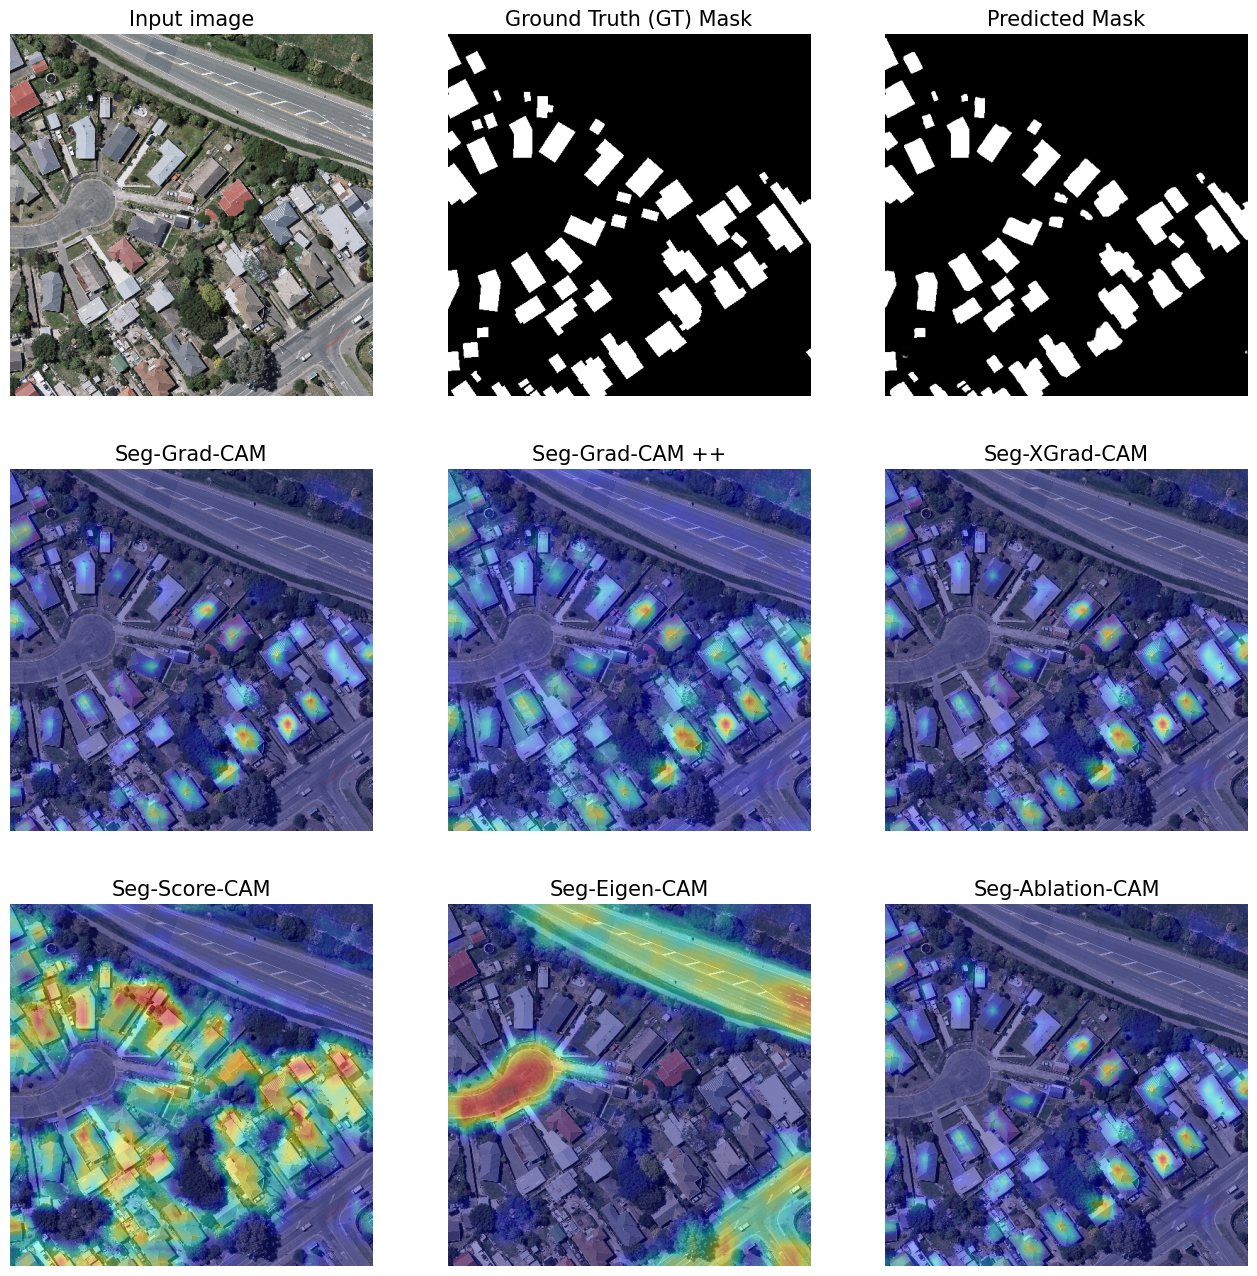

In [6]:
# Apply the adapted CAM-based Extensions on the considered dataset 

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()




def defaultScales():
    classes_cmap = plt.get_cmap('Spectral', 20)
    scale_fig = 2
    fonts = 15
    scatter_size = 330 * scale_fig
    return classes_cmap, scale_fig, fonts, scatter_size


def show_cam_image_whu(full_img_rgba, grayscale_cam_EX, image_weight):
    heatmap_sgc = cv2.applyColorMap(np.uint8(255 * grayscale_cam_EX), cv2.COLORMAP_JET)
    heatmap_sgc = cv2.cvtColor(heatmap_sgc, cv2.COLOR_BGR2RGB)
    heatmap_sgc = np.float32(heatmap_sgc) / 255
    if full_img.shape[-1]==4:
        heatmap_sgc = cv2.cvtColor(heatmap_sgc,cv2.COLOR_RGB2RGBA)
    Exmap_sgc = (1 - image_weight) * heatmap_sgc + image_weight * full_img_rgba
    Exmap_sgc = Exmap_sgc / np.max(Exmap_sgc)
    Exmap_sgc = np.uint8(255 * Exmap_sgc)

    return Exmap_sgc, heatmap_sgc


def prob_2_entropy(prob):
    """ convert probabilistic prediction maps to weighted self-information maps
    """
    n, c, h, w = prob.size()
    return -torch.mul(prob, torch.log2(prob + 1e-30)) / np.log2(c)

def XAI_EVAL_M2(thres,grayscale_cam_EX, full_img_gt, full_img, model, rrp_info,target_category):
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    union_gt_sgc = np.ma.mask_or(full_img_gt,im_bw_sgc)

    E_sgc = full_img * union_gt_sgc[..., None]
    x_sgc = totensor(E_sgc)
    x_sgc = x_sgc.cuda()
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc,rrp_info)

    mask_tensor_sgc = y_pred_sgc[0,...]
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)
        
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, im_bw_sgc,E_sgc
    


images_dir = r'./dataset/images'
gt_dir = r'./dataset/gt'





ticks = np.linspace(0, 1, 6, endpoint=True)
classes_cmap, scale_fig, fonts, scatter_size = defaultScales()




decoder_idx = 1
n_xai = 6
n_imgs = 1
target_layers =  [model.decoder.blocks[decoder_idx - 1]]
target_category = 0
XAI_method = ["grad_cam", "hires_cam", "ew_cam", "grad_cam_pp", "x_grad_cam","score_cam", "layer_cam", "eigen_cam", "eigen_grad_cam"]

image_weight = 0.006

directory_images = os.fsencode(images_dir)
directory_gt = os.fsencode(gt_dir)


number_testing_images = 0

Model_Seg_Score = np.zeros((n_imgs))
Model_Seg_Entropy = np.zeros((n_imgs))

Seg_Score = np.zeros((n_xai, n_imgs))
Seg_Entropy = np.zeros((n_xai, n_imgs))
counter = 0


for (file_img, file_gt) in zip(os.listdir(directory_images), os.listdir(directory_gt) ):

    print(file_img, file_gt)
    if file_img == file_gt:
        number_testing_images = number_testing_images + 1
        print("Testing Image: ", number_testing_images)
        filename = os.fsdecode(file_img)
        filename_gt = os.fsdecode(file_gt)
        if filename.endswith(".png") and filename_gt.endswith(".png"):         
            raster_file = rio.open(f'{images_dir}/{filename}')
            full_img = raster_file.read().transpose(1,2,0)
            full_img,rrp_info = ratio_resize_pad(full_img, ratio = None)
            full_img_rgba = full_img
            print("Input Image Shape: ", full_img.shape)
            if full_img.shape[-1]==4:full_img = cv2.cvtColor(full_img,cv2.COLOR_RGBA2RGB) #WHU images are RGBA
            # read gt mask
            raster_file_gt = rio.open(f'{gt_dir}/{filename_gt}')
            full_img_gt = raster_file_gt.read().transpose(1,2,0)
            full_img_gt,rrp_info_gt = ratio_resize_pad(full_img_gt, ratio = None) 
            full_img_gt = np.float32(full_img_gt) / np.max(full_img_gt)
            print("GT mask shape: ", full_img_gt.shape)
            
            
            full_img = normalize(full_img)
            x = totensor(full_img)
            x = x.cuda()
            
            with torch.no_grad():
                y_pred = model(x)
                y_pred = unpad_resize(y_pred,rrp_info)
    
    
    
            mask_tensor = y_pred[0,...]
            print('predicated tensor shape: ', mask_tensor.shape)
            mask = y_pred[0,...].cpu().numpy().transpose(1,2,0)

            target_mask_float = np.float32(mask[:,:,target_category]) * full_img_gt
            target_Confidence_score = target_mask_float[np.nonzero(target_mask_float)]
            target_Confidence_score = np.mean(target_Confidence_score)
            print("Model Target Confidence Score: ", target_Confidence_score)
            
            logist_softmax_entropy = prob_2_entropy(y_pred)
            target_entropy_mask = logist_softmax_entropy[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
            target_entropy_mask_class = target_entropy_mask[:,:,target_category] * full_img_gt
            model_entropy = np.mean(target_entropy_mask_class)
            print("Model Target Entropy Score: ", model_entropy )
                  
            
            targets = [SemanticSegmentationTarget(target_category, target_mask_float)]
         
            nan_condition = np.count_nonzero(target_mask_float)
            if nan_condition != 0:
                
                print('running seg-grad-cam...')
                with GRADCAM_Extensions(extension = XAI_method[0], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
                    grayscale_cam_EX = cam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX, image_weight)
                    [confidence_sgc_M2, entropy_sgc_M2, bw_sgc,E_sgc] = XAI_EVAL_M2(0.4,grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category)
                    print("SGC Target Confidence Score: ", confidence_sgc_M2," Entropy Score: ", entropy_sgc_M2)
                    
                print('running GradCam++ ...')
                with GRADCAM_Extensions(extension = XAI_method[3], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as campp:
                    grayscale_cam_EX_Plusplus = campp(input_tensor=x, targets=targets)[0, :]
                    [Exmap_sgcpp, heatmap_sgcpp_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_Plusplus, image_weight)
                    [confidence_sgcpp_M2, entropy_sgcpp_M2, bw_sgcpp,E_sgcpp] = XAI_EVAL_M2(0.4,grayscale_cam_EX_Plusplus, full_img_gt, full_img, model, rrp_info, target_category)
                    print("SGC-PP Target Confidence Score: ", confidence_sgcpp_M2," Entropy Score: ", entropy_sgcpp_M2)
        
                print('running XGradCam...')
                with GRADCAM_Extensions(extension = XAI_method[4], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as xcam:
                    grayscale_cam_EX_X = xcam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_Xsgc, heatmap_Xsgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_X, image_weight)
                    [confidence_Xsgc_M2, entropy_Xsgc_M2, bw_sgcx,E_sgcx] = XAI_EVAL_M2(0.4,grayscale_cam_EX_X, full_img_gt, full_img, model, rrp_info, target_category)
                    print("SGC-X Target Confidence Score: ", confidence_Xsgc_M2," Entropy Score: ", entropy_Xsgc_M2)
        
        
                print('running ScoreCam...')
                with GRADCAM_Extensions(extension = XAI_method[5], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as scorecam:
                    grayscale_cam_EX_Score = scorecam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_scoresgc, heatmap_scoresgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_Score, image_weight)
                    [confidence_ssgc_M2, entropy_ssgc_M2, bw_sgcs,E_sgcs] = XAI_EVAL_M2(0.4,grayscale_cam_EX_Score, full_img_gt, full_img, model, rrp_info, target_category)
                    print("SGC-Score Target Confidence Score: ", confidence_ssgc_M2," Entropy Score: ", entropy_ssgc_M2)
        
            
                print('running EigenCam...')
                with GRADCAM_Extensions(extension = XAI_method[7], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as ecam:
                    grayscale_cam_EX_eigen = ecam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_eigensgc, heatmap_eigensgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_eigen, image_weight)
                    [confidence_esgc_M2, entropy_esgc_M2, bw_sgce, E_sgce] = XAI_EVAL_M2(0.4,grayscale_cam_EX_eigen, full_img_gt, full_img, model, rrp_info,target_category)
                    print("SGC-eigen Target Confidence Score: ", confidence_esgc_M2," Entropy Score: ", entropy_esgc_M2)
                  
                   
        
                print('running AblationCAM...')
                with GRADCAMEXTENDED_AblationCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as ablcam:
                    grayscale_cam_EX_abl = ablcam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_ablsgc, heatmap_ablsgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_abl, image_weight)
                    [confidence_asgc_M2, entropy_asgc_M2, bw_sgca, E_sgca] = XAI_EVAL_M2(0.4,grayscale_cam_EX_abl, full_img_gt, full_img, model, rrp_info, target_category)
                    print("SGC-Ablbation Target Confidence Score: ", confidence_asgc_M2," Entropy Score: ", entropy_asgc_M2)
        
        
        
                Model_Seg_Score[counter] = target_Confidence_score
                Model_Seg_Entropy[counter] = model_entropy
                
                Seg_Score[0,counter] = confidence_sgc_M2
                Seg_Score[1,counter] = confidence_sgcpp_M2
                Seg_Score[2,counter] = confidence_Xsgc_M2 
                Seg_Score[3,counter] = confidence_ssgc_M2
                Seg_Score[4,counter] = confidence_esgc_M2
                Seg_Score[5,counter] = confidence_asgc_M2          
                
                Seg_Entropy[0,counter] = entropy_sgc_M2
                Seg_Entropy[1,counter] = entropy_sgcpp_M2
                Seg_Entropy[2,counter] = entropy_Xsgc_M2
                Seg_Entropy[3,counter] = entropy_ssgc_M2 
                Seg_Entropy[4,counter] = entropy_esgc_M2 
                Seg_Entropy[5,counter] = entropy_asgc_M2  
                counter = counter + 1

                if(number_testing_images == 2):
                    break
              
        
            
                fig = plt.figure(figsize=(8 * scale_fig, 8 * scale_fig))
        
                plt.subplot(3,3,1)
                plt.axis('off')
                plt.imshow(full_img_rgba)
                plt.title('Input image', fontsize=fonts)
        
                plt.subplot(3,3,2)
                plt.axis('off')
                plt.imshow(full_img_gt, cmap='gray', vmin=0, vmax=1)
                plt.title('Ground Truth (GT) Mask', fontsize=fonts)
        
                plt.subplot(3,3,3)
                plt.axis('off')
                plt.imshow(target_mask_float,  cmap='gray', vmin=0, vmax=1)
                plt.title('Predicted Mask', fontsize=fonts)
                
                plt.subplot(3,3,4)
                plt.axis('off')
                plt.imshow(Exmap_sgc)
                plt.title('Seg-Grad-CAM', fontsize=fonts)
                
                plt.subplot(3,3,5)
                plt.axis('off')
                plt.imshow(Exmap_sgcpp)
                plt.title('Seg-Grad-CAM ++', fontsize=fonts)
                
                plt.subplot(3,3,6)
                plt.axis('off')
                plt.imshow(Exmap_Xsgc)
                plt.title('Seg-XGrad-CAM', fontsize=fonts)
                
                plt.subplot(3,3,7)
                plt.axis('off')
                plt.imshow(Exmap_scoresgc)
                plt.title('Seg-Score-CAM', fontsize=fonts)
                
                plt.subplot(3,3,8)
                plt.axis('off')
                plt.imshow(Exmap_eigensgc)
                plt.title('Seg-Eigen-CAM', fontsize=fonts)
                
                
                plt.subplot(3,3,9)
                plt.axis('off')
                plt.imshow(Exmap_ablsgc)
                plt.title('Seg-Ablation-CAM', fontsize=fonts)
                
                # Save the full figure...
                fig.savefig('./results/SegGradCam_Extensions_{}_{}.png'.format(filename,decoder_idx), bbox_inches='tight', pad_inches=0)
    
    
